# Digit Eye


In [1]:
%load_ext autoreload
%autoreload 2
import torch

from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from typing import cast

from src.models import Cifar10Model
from src.models.common.types import EpochResult

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(1)

/home/anamnesis/Documents/UR/Aprendizaje Automático de Máquina/Proyecto Final/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_id = "cifar10"
def load_torch_dataset(split: str):
    dataset = load_dataset(dataset_id, split = split).with_format("torch") # type: ignore
    return cast(Dataset, dataset)

train_set = load_torch_dataset("train")
test_set = load_torch_dataset("test")

def collate_fn(batches):
    features = torch.stack([batch["img"] for batch in batches])
    labels = torch.tensor([batch["label"] for batch in batches])
    return features.float(), labels.long()

batch_size = 128
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

Found cached dataset cifar10 (/home/anamnesis/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
Found cached dataset cifar10 (/home/anamnesis/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


In [3]:
model_path = "./assets/digit_eye"
model = Cifar10Model(path=model_path)

train_history = model.train(epochs=10, train_loader=train_loader, test_loader=test_loader)
model.load_weights()
model.evaluate(test_loader)



N° Epoch 0
Trainning loss: 0.013857526664733886	Accuracy: 0.38162
Test loss: 0.015020396995544433	Accuracy: 0.3555
Better Accuracy Found: -inf -> 0.3555. Saving Model...

N° Epoch 1
Trainning loss: 0.012246523303985596	Accuracy: 0.4536
Test loss: 0.013573711752891541	Accuracy: 0.411
Better Accuracy Found: 0.3555 -> 0.411. Saving Model...

N° Epoch 2
Trainning loss: 0.011494333777427673	Accuracy: 0.48768
Test loss: 0.01151046404838562	Accuracy: 0.4814
Better Accuracy Found: 0.411 -> 0.4814. Saving Model...

N° Epoch 3
Trainning loss: 0.01099975510597229	Accuracy: 0.50746
Test loss: 0.012609583389759064	Accuracy: 0.4515

N° Epoch 4
Trainning loss: 0.010704677309989929	Accuracy: 0.52178
Test loss: 0.013580440509319305	Accuracy: 0.4197

N° Epoch 5
Trainning loss: 0.010487741627693177	Accuracy: 0.53112
Test loss: 0.01135592736005783	Accuracy: 0.4969
Better Accuracy Found: 0.4814 -> 0.4969. Saving Model...

N° Epoch 6
Trainning loss: 0.010257134010791778	Accuracy: 0.54338
Test loss: 0.01427

{'accuracy': 0.504, 'average_loss': 0.011293033254146576}

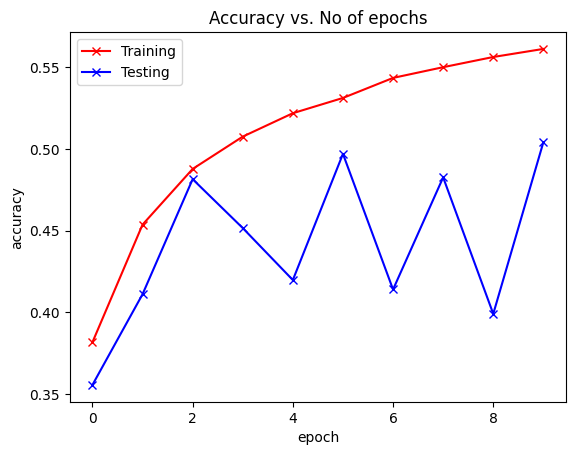

In [4]:
def plot_accuracies(history: list[EpochResult]):
    testing_accuracies = [x["testing"]["accuracy"] for x in history]
    training_accuracies = [x["training"]["accuracy"] for x in history]

    plt.plot(training_accuracies, "-rx")
    plt.plot(testing_accuracies, "-bx")

    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(["Training", "Testing"])
    plt.title("Accuracy vs. No of epochs")


plot_accuracies(train_history)


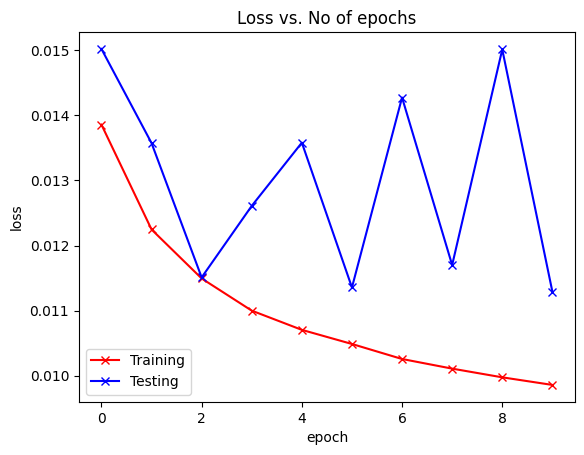

In [5]:
def plot_losses(history: list[EpochResult]):
    training_losses = [x['training']['average_loss'] for x in history]
    testing_losses = [x['testing']['average_loss'] for x in history]


    plt.plot(training_losses, "-rx")
    plt.plot(testing_losses, "-bx")

    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Testing"])
    plt.title("Loss vs. No of epochs")
plot_losses(train_history)

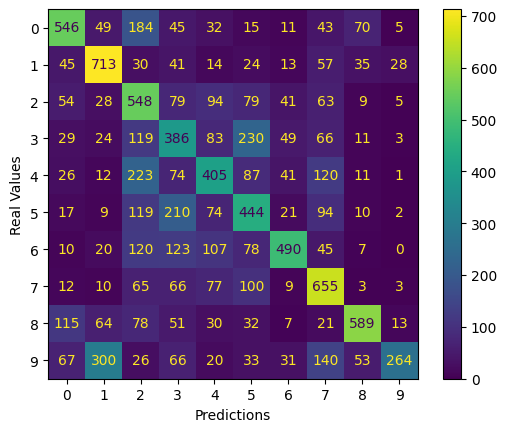

In [6]:
def plot_preds(model: Cifar10Model):
    y_pred = []
    y_true = []

    for batch in test_loader:
        batch_step = model.batch_step(batch)
        y_pred.extend(batch_step["preds"])
        y_true.extend(batch[1].data)

    y_pred = [y.item() for y in y_pred]
    y_true = [y.item() for y in y_true]

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    
    plt.xlabel("Predictions")
    plt.ylabel("Real Values")
    plt.show()

plot_preds(model)